In [1]:
import torch
import torch.nn as nn
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FNO2dAR(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, width):
        """
        in_channels: number of time steps (features) per spatial location
        out_channels: number of output channels 
        modes1, modes2: number of Fourier modes to keep
        """
        super(FNO2d, self).__init__()
        self.width = width
        # Lift the input (here, in_channels = T) to a higher-dimensional feature space.
        self.fc0 = nn.Linear(in_channels, self.width)

        # Fourier layers and pointwise convolutions 
        self.conv0 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)

        self.conv1 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)

        self.conv2 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)

        self.conv3 = SpectralConv2d(self.width, self.width, modes1, modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        """
        x: input of shape [B, T, H, W]
        """
        # Permute to [B, H, W, T] so each spatial location has a feature vector of length T
        x = x.permute(0, 2, 3, 1)
        # Lift to higher-dimensional space
        x = self.fc0(x)
        # Permute to [B, width, H, W] for convolutional operations
        x = x.permute(0, 3, 1, 2)

        # Apply Fourier layers with local convolution
        x = self.conv0(x) + self.w0(x)
        x = nn.GELU()(x)
        x = self.conv1(x) + self.w1(x)
        x = nn.GELU()(x)
        x = self.conv2(x) + self.w2(x)
        x = nn.GELU()(x)
        x = self.conv3(x) + self.w3(x)

        # Permute back and project to output space
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = nn.GELU()(x)
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# Spectral convolution layer remains unchanged
class SpectralConv2dAR(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy, ioxy -> boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1,
            device=x.device, dtype=torch.cfloat
        )
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :, :self.modes1, :self.modes2], self.weights
        )
        x = torch.fft.irfft2(out_ft, s=x.shape[-2:])
        return x

In [3]:
nu=1e-4
k_cutoff_fine = 7.5
# ----------------------------
# Data Loader: Load full trajectory (20 time steps) for evaluation
# ----------------------------
def load_single_sample_full(idx=0):
   # fine_u = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_fine_nu={1e-3}_mode=10_no_dealias.npy')
    #fine_u = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_fine_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy') #np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_fine_nu={1e-4}_mode=10_no_dealias_64to128_with_forcing.npy')
    fine_u = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_fine_256_nu0.0001_k7.5_test_data.npy')
    sample_u = fine_u 
    sample_u = torch.tensor(sample_u, dtype=torch.float32)
    return sample_u

In [4]:
# ----------------------------
# Evaluation: Iterative Future Extrapolation with AB3 on the Coarse Grid
# ----------------------------

device = 'cpu'#torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Initialize models and load saved weights
model_u = FNO2d(100, 100, 16, 16, 64).to(device)

model_u.load_state_dict(torch.load(f"/pscratch/sd/h/hbassi/FNO_fine_tuning_NS_64to256_nu={1e-4}_mode={7.5}_best_model.pth", map_location=device))
model_u.eval()

FNO2d(
  (fc0): Linear(in_features=100, out_features=64, bias=True)
  (conv0): SpectralConv2d()
  (w0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv1): SpectralConv2d()
  (w1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2): SpectralConv2d()
  (w2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): SpectralConv2d()
  (w3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=100, bias=True)
)

In [5]:
# Load full trajectory sample (20 time steps) for U and V\
idx = 0
sample_u = load_single_sample_full(idx)[idx]
sample_u = sample_u.to(device)  # [20, H, W]

In [6]:
sample_u.shape

torch.Size([1001, 256, 256])

In [7]:
pred_u_c = []
from tqdm import trange
window_u = sample_u[:100, :, :].unsqueeze(0)

In [8]:
window_u.shape

torch.Size([1, 100, 256, 256])

In [9]:
for i in trange(850):
    outputs_u = model_u(window_u)
    final_time = outputs_u.squeeze(0)[-1]
    pred_u_c.append(final_time)
    #print(window_u.shape, final_time.shape)
    window_u = torch.cat([window_u[:, 1:], final_time.unsqueeze(0).unsqueeze(0)], dim=1)

100%|██████████| 850/850 [01:07<00:00, 12.56it/s]


In [10]:
pred_u_c = torch.stack(pred_u_c, dim=0)

In [11]:
pred_u_c.shape

torch.Size([850, 256, 256])

In [12]:
gt_u = sample_u[100:]

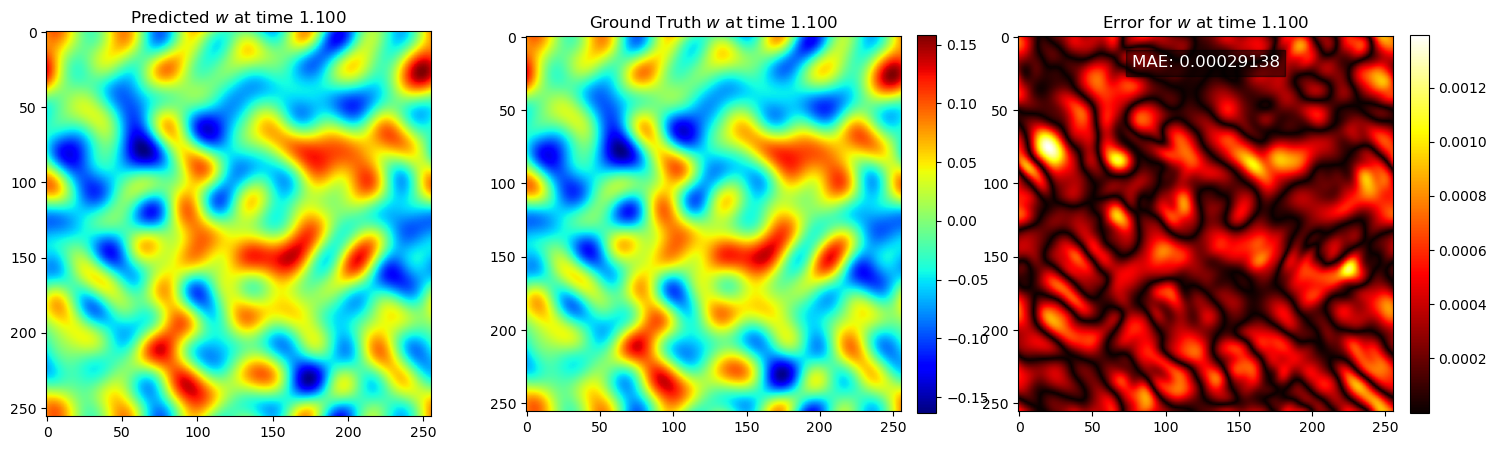

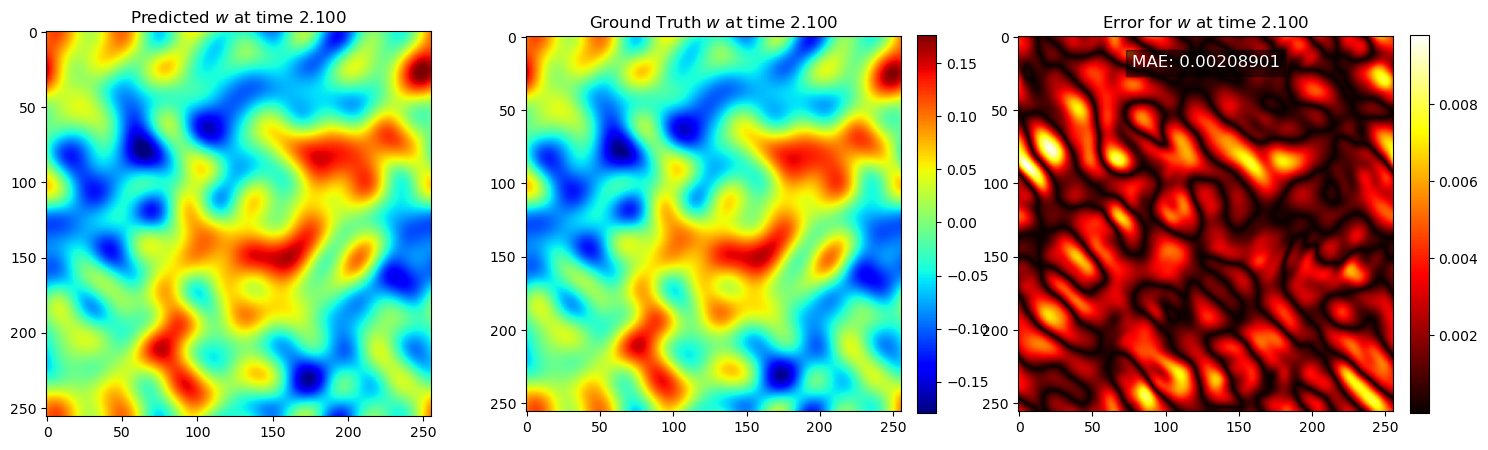

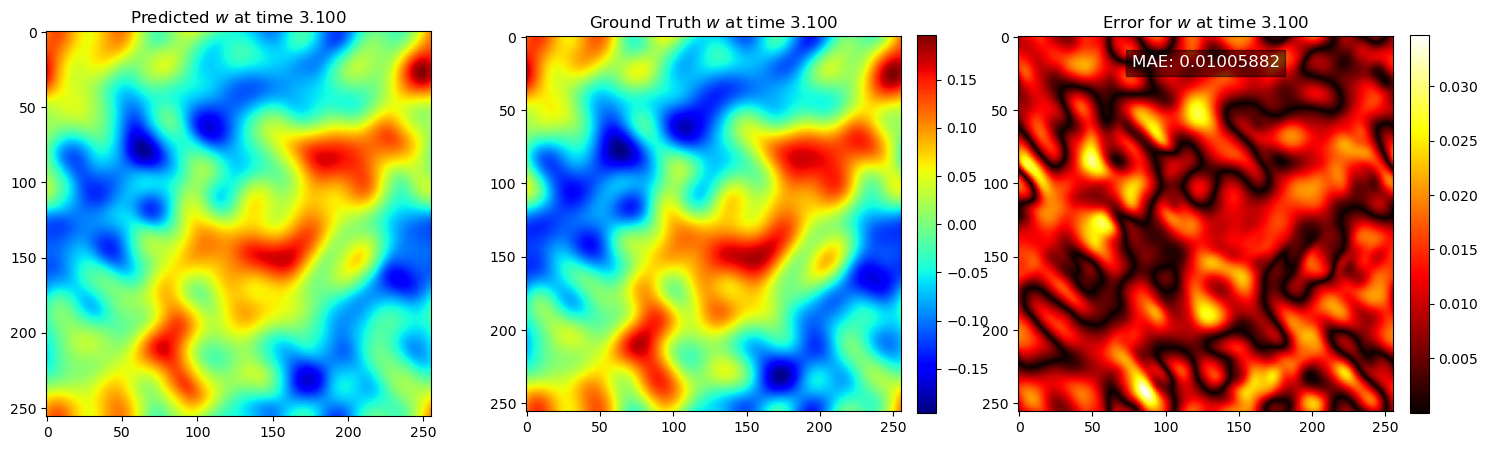

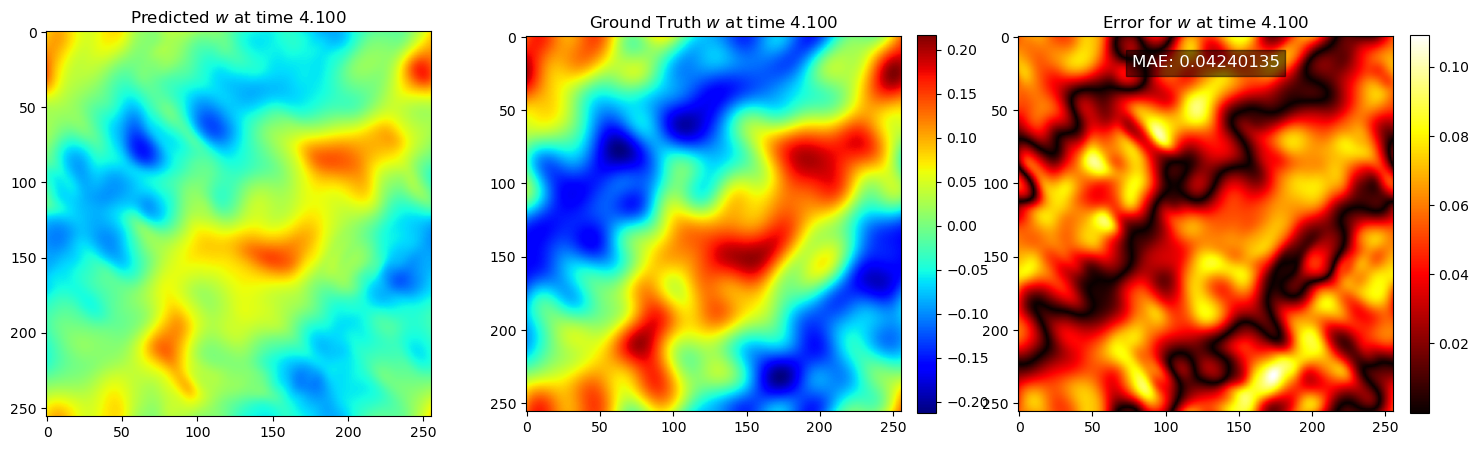

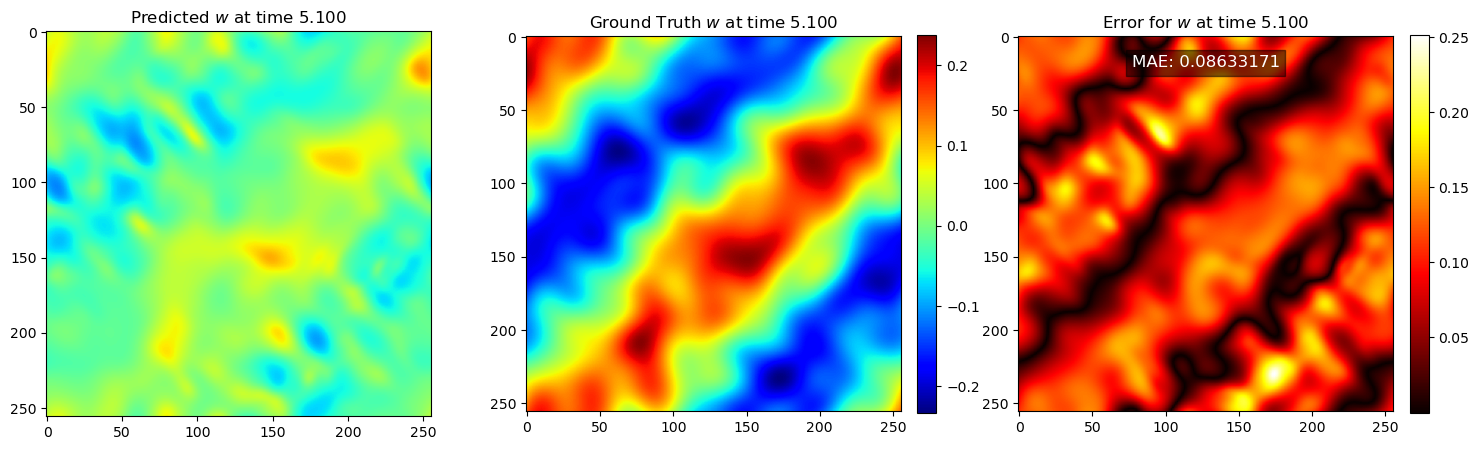

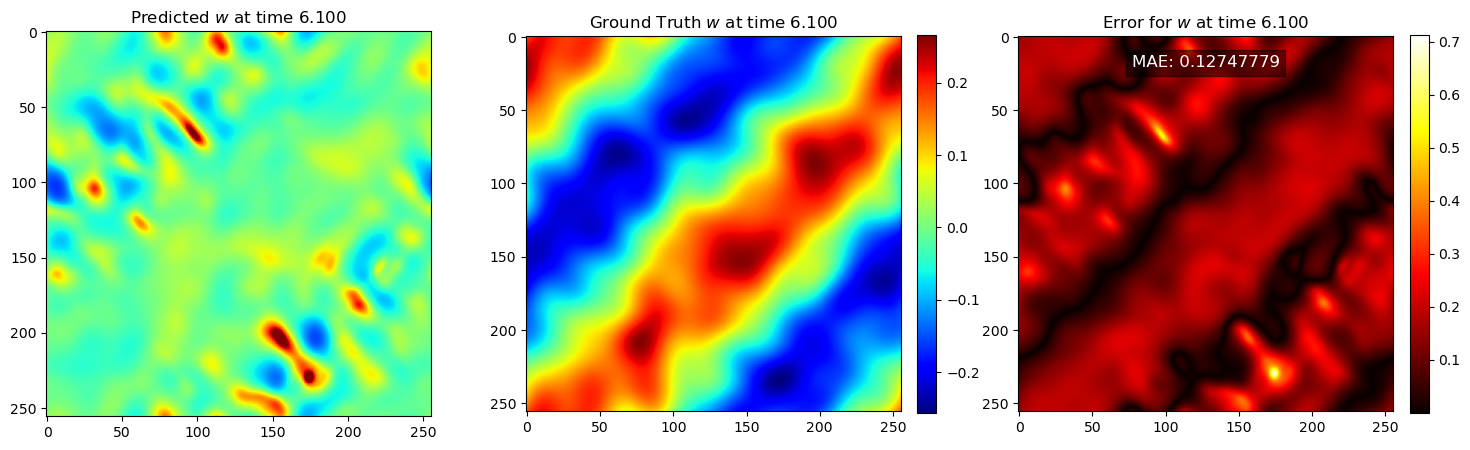

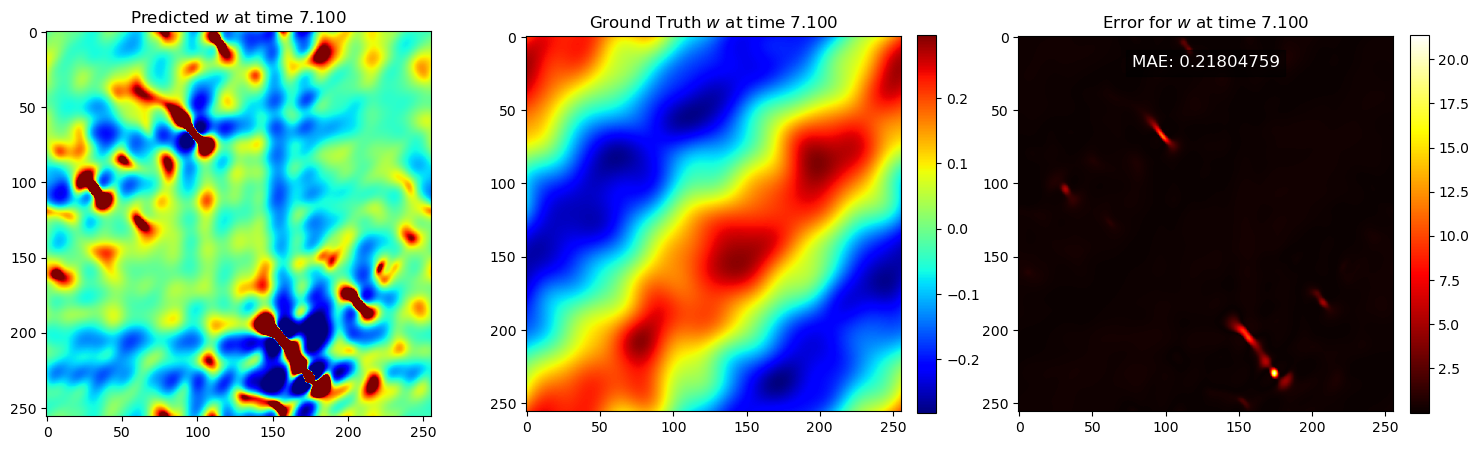

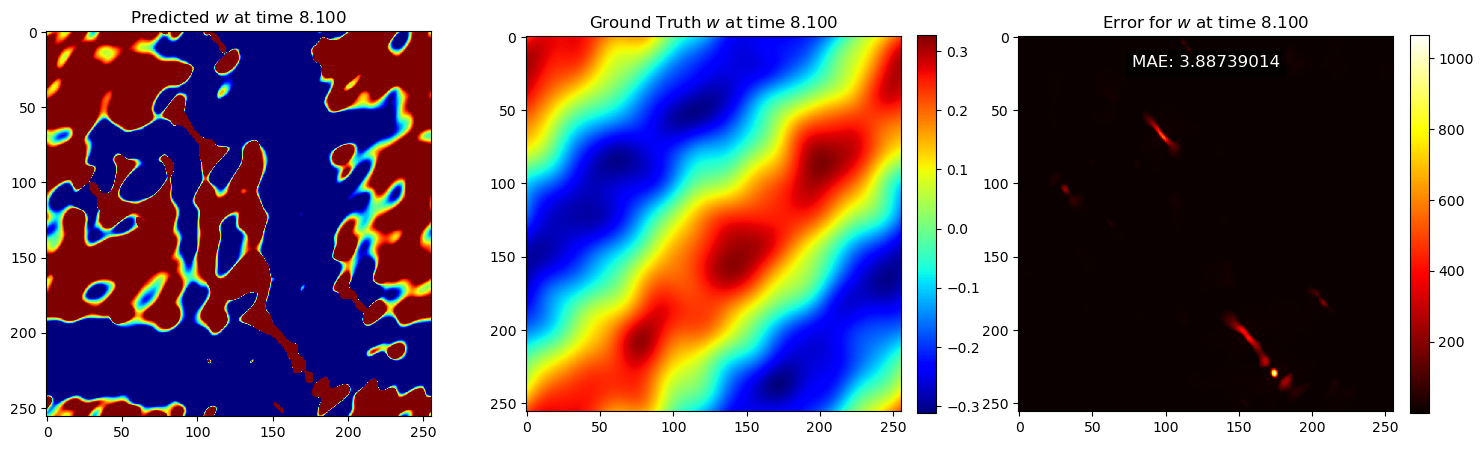

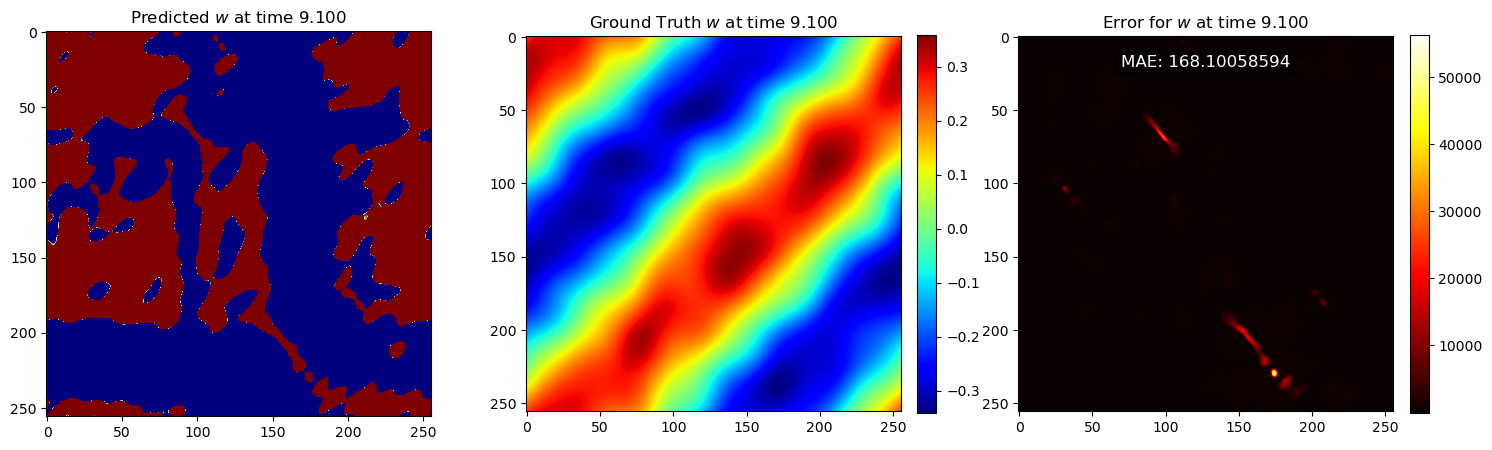

In [14]:
# directory used for the figure PDFs
import os
fig_dir = "./figures/ns_results/fno"
maes = []
for i in range(0, 900, 100):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # --- time label -----------------------------------------------------------
    time_value = 1 + 0.01 * (10 + i)
    time_str   = f"{time_value:.3f}"

    # --- per-frame colour scale from ground truth -----------------------------
    gt_frame   = gt_u[i].detach().cpu().numpy()
    vmin_g, vmax_g = gt_frame.min(), gt_frame.max()

    # ---------------- Predicted w (no colour-bar) ------------------------------
    pred_frame = pred_u_c[i].detach().cpu().numpy()
    axes[0].imshow(pred_frame, cmap='jet', vmin=vmin_g, vmax=vmax_g)
    axes[0].set_title(fr"Predicted $w$ at time {time_str}")

    # ---------------- Ground-Truth w (+ colour-bar) ----------------------------
    im_gt = axes[1].imshow(gt_frame, cmap='jet', vmin=vmin_g, vmax=vmax_g)
    axes[1].set_title(fr"Ground Truth $w$ at time {time_str}")
    fig.colorbar(im_gt, ax=axes[1], fraction=0.046, pad=0.04)

    # ----------------------- Error map (+ bar) ---------------------------------
    mae = np.abs(pred_frame - gt_frame)
    overall_mae = mae.mean()
    maes.append(overall_mae)

    im_err = axes[2].imshow(mae, cmap='hot')
    axes[2].set_title(fr"Error for $w$ at time {time_str}")
    fig.colorbar(im_err, ax=axes[2], fraction=0.046, pad=0.04)

    axes[2].text(
        0.5, 0.95, f"MAE: {overall_mae:.8f}",
        transform=axes[2].transAxes,
        fontsize=12, color='white', ha='center', va='top',
        bbox=dict(facecolor='black', alpha=0.5)
    )

    # --- save figure -----------------------------------------------------------
    # fig_path = (
    #     f"{fig_dir}/phase2_fno_NavierStokes_test_traj_"
    #     f"nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_without_forcing_t={time_str}.pdf"
    # )
    #plt.savefig(fig_path)
    plt.show()

In [18]:
import os
import imageio


# Create a folder to store the frames
os.makedirs('fno_frames', exist_ok=True)

maes = []
filenames = []

for i in trange(0, 900):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_u_c[i].detach().cpu().numpy(), cmap='jet')
    plt.title(fr"Predicted $w$ at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(fr"Ground Truth $w$ at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    mae = abs(pred_u_c[i] - gt_u[i]).detach().cpu().numpy()
    plt.imshow(mae, cmap='hot')
    plt.title(fr"Error for $w$ at time {time_str}")
    plt.colorbar()
    
    overall_mae = np.mean(mae)
    maes.append(overall_mae)
    # plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
    #          transform=plt.gca().transAxes,
    #          fontsize=12, color='white', ha='center', va='top',
    #          bbox=dict(facecolor='black', alpha=0.5))
    
    # Save the figure as a PNG file
    filename = f"fno_frames/frame_{i:03d}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    

# Create a GIF from the saved images
gif_filename = 'fno_extrapolation_animation.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1e-7) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as {gif_filename}")

# Optionally, remove the temporary frame files if they're no longer needed
for filename in filenames:
    os.remove(filename)


100%|██████████| 900/900 [06:12<00:00,  2.41it/s]
/tmp/ipykernel_1441973/3088074351.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as fno_extrapolation_animation.gif


In [19]:
np.save(f'fno_maes_NavierStokes_test_traj_fine_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_without_forcing_new.npy', maes)

In [14]:
# for i in range(10):
#     plt.figure(figsize=(18, 5))
#     time_value = 0.1 * (11 + i)
#     time_str = f"{time_value:.3f}" 

#     # Left plot: Predicted U
#     plt.subplot(1, 4, 1)
#     plt.imshow(pred_u_c[i].detach().cpu().numpy(), cmap='hot')
#     plt.title(f"Predicted U at time {time_str}")
#     plt.colorbar()

#     # Middle plot: Ground Truth U
#     plt.subplot(1, 4, 2)
#     plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='hot')
#     plt.title(f"Ground Truth U at time {time_str}")
#     plt.colorbar()

#     # Third plot: Absolute Error (AE)
#     plt.subplot(1, 4, 3)
#     mae = abs(pred_u_c[i] - gt_u[i]).detach().cpu().numpy()
#     plt.imshow(mae, cmap='jet')
#     plt.title(f"Error for U at time {time_str}")
#     plt.colorbar()
#     overall_mae = np.mean(mae)  
#     plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
#              transform=plt.gca().transAxes,
#              fontsize=12, color='white', ha='center', va='top',
#              bbox=dict(facecolor='black', alpha=0.5))

#     # Fourth plot: Error along center slice
#     plt.subplot(1, 4, 4)
#     plt.plot(mae[:, 64])
#     plt.title(f"Error for U at time {time_str}")
    
#     # Set y-ticks on the right
#     plt.gca().yaxis.tick_right()
#     #plt.savefig(f'./figures/fno/single_loss/training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
#     plt.show()


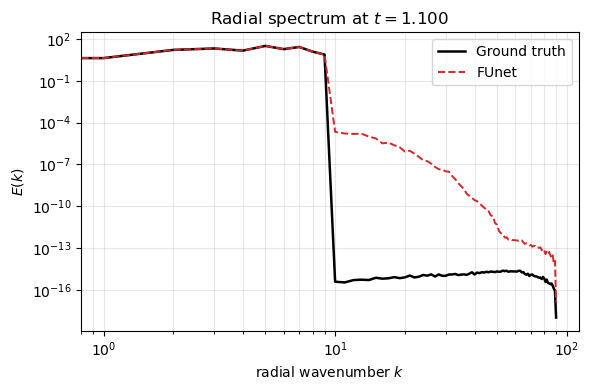

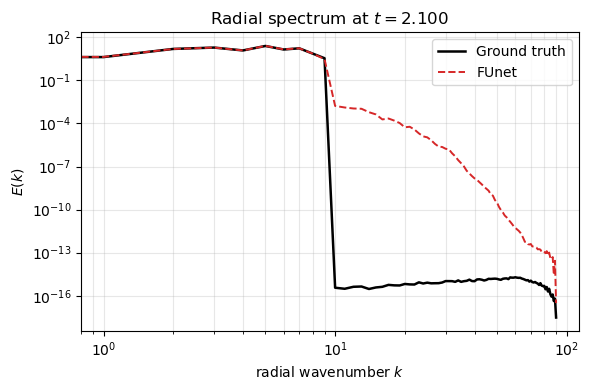

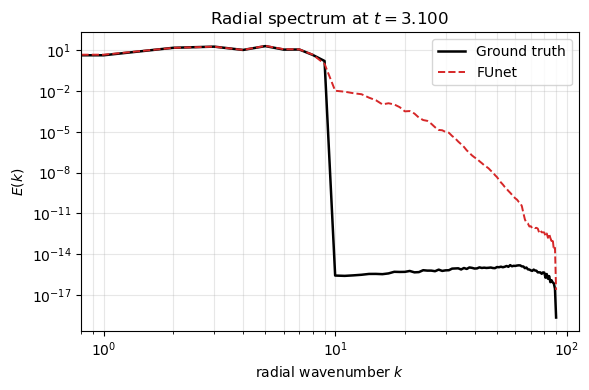

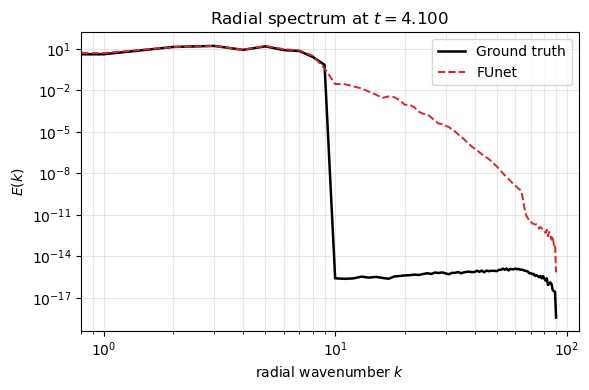

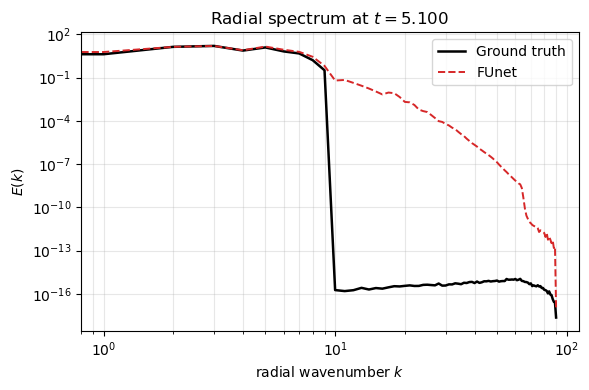

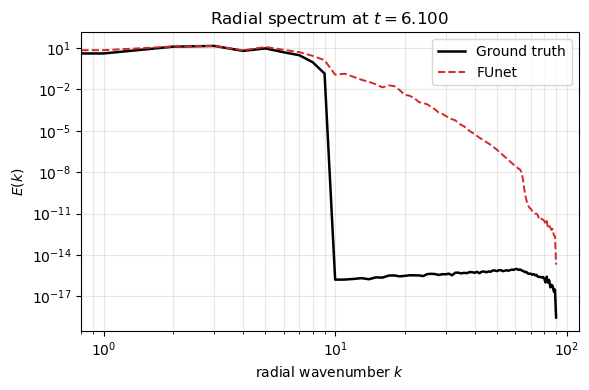

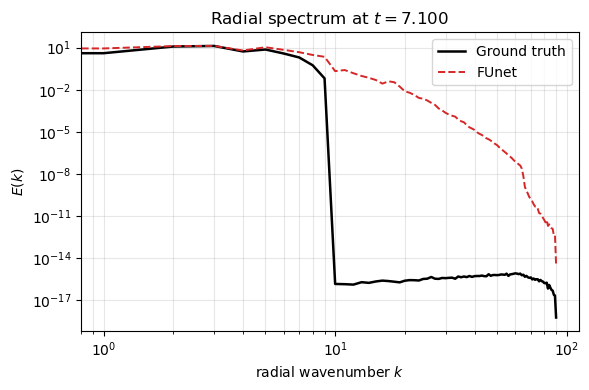

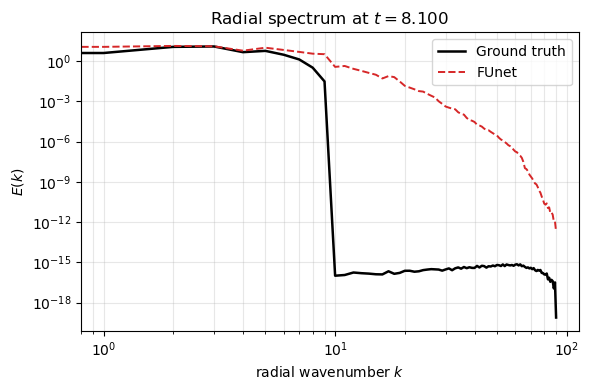

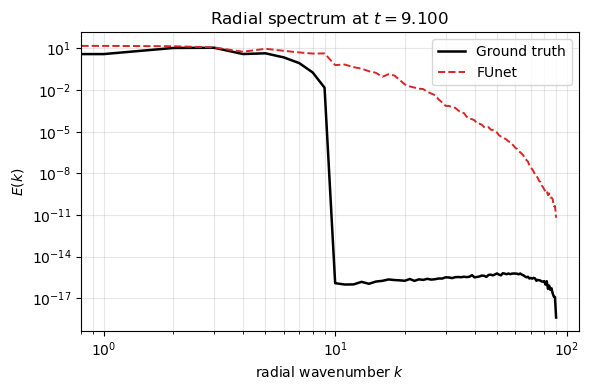

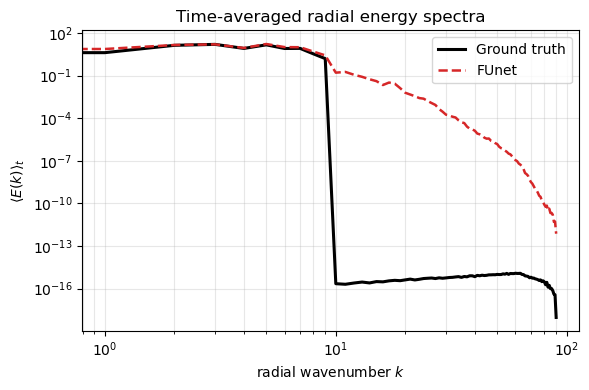

Relative ℓ₂ error (Prediction  vs. GT): 1.7839e-01
Global relative \ell_2 error of predicted dynamics vs. ground truth: 3.9973e-01


In [16]:
# ======================================================================
#  Compare radial energy spectra: Pred vs. Bicubic Upsample vs. GT
#  • Adds a vertical gray line at the coarse-grid Nyquist cutoff
#    (k = N_coarse/2) on every spectrum plot, excluded from the legend.
# ======================================================================

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def radial_energy_spectrum(u):
    """One-sided Parseval-normalised radial spectrum."""
    N = u.shape[0]
    u_hat = np.fft.fftshift(np.fft.fft2(u))
    ed    = (np.abs(u_hat) ** 2) / N**2
    kx = np.fft.fftshift(np.fft.fftfreq(N)) * N
    KX, KY = np.meshgrid(kx, kx, indexing="ij")
    kr = np.sqrt(KX**2 + KY**2).astype(int)
    E  = np.bincount(kr.ravel(), ed.ravel(), minlength=kr.max() + 1)
    return np.arange(len(E)), E


# ----------------------------------------------------------------------
eps = 1e-12
spec_gt_ts, spec_pred_ts, spec_up_ts = [], [], []
k_ref = None                                       # global k-axis

for i in range(0, 900, 100):
    # ---------- timestamp ---------------------------------------------
    t_val   = 1 + 0.01 * (10 + i)
    t_label = f"{t_val:.3f}"

    # ---------- arrays -------------------------------------------------
    gt_np   = gt_u[i].detach().cpu().numpy()
    pred_np = pred_u_c[i].detach().cpu().numpy()

    
    # ---------- spectra ------------------------------------------------
    k_gt,  E_gt  = radial_energy_spectrum(gt_np)
    k_pr,  E_pr  = radial_energy_spectrum(pred_np)


    max_len = max(len(k_gt), len(k_pr),
                  len(k_ref) if k_ref is not None else 0)
    if k_ref is None or max_len > len(k_ref):
        k_ref = np.arange(max_len)
    pad = lambda arr: np.pad(arr, (0, max_len - len(arr)), "constant")

    spec_gt_ts .append(pad(E_gt))
    spec_pred_ts.append(pad(E_pr))
  
    np.save(f'./data/fno_t={t_label}_radial_spectrum_NS_test_traj_nu=0.0001_mode=7.5_no_dealias_32to128_without_forcing.npy', E_pr)
    # ---------- plot snapshot -----------------------------------------
    plt.figure(figsize=(6, 4))
    plt.loglog(k_ref, pad(E_gt),  "k-",   lw=1.8, label="Ground truth")
    plt.loglog(k_ref, pad(E_pr),  "C3--", lw=1.4, label="FUnet")
    plt.xlabel(r"radial wavenumber $k$")
    plt.ylabel(r"$E(k)$")
    plt.title(rf"Radial spectrum at $t={t_label}$")
    plt.grid(alpha=0.3, which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
#  Time-averaged spectra
# ----------------------------------------------------------------------
E_gt_avg   = np.mean(np.stack(spec_gt_ts , axis=0), axis=0)
E_pred_avg = np.mean(np.stack(spec_pred_ts, axis=0), axis=0)


plt.figure(figsize=(6, 4))
plt.loglog(k_ref, E_gt_avg,   "k-",   lw=2.2, label="Ground truth")
plt.loglog(k_ref, E_pred_avg, "C3--", lw=1.8, label="FUnet")
plt.xlabel(r"radial wavenumber $k$")
plt.ylabel(r"$\langle E(k) \rangle_t$")
plt.title("Time-averaged radial energy spectra")
plt.grid(alpha=0.3, which="both")
plt.legend()
plt.tight_layout()
plt.savefig('./figures/ns_results/fno/phase2_fno_compare_energy_spectrum_upsample_NavierStokes_test_traj_nu=0.0001_mode=7.5_no_dealias_32to128_without_forcing.pdf')
plt.show()

# ----------------------------------------------------------------------
#  Relative ℓ₂ differences (time-averaged spectra)
# ----------------------------------------------------------------------
rel_l2_pred = np.linalg.norm(E_pred_avg - E_gt_avg) / (np.linalg.norm(E_gt_avg) + eps)
np.save('./data/fno_avg_radial_spectrum_NS_test_traj_nu=0.0001_mode=7.5_no_dealias_32to128_without_forcing.npy', E_pred_avg)

print(f"Relative ℓ₂ error (Prediction  vs. GT): {rel_l2_pred:.4e}")
rel_l2_flow = torch.norm(pred_u_c - gt_u[1:]) / (torch.norm(gt_u[1:]) + eps)
print(f"Global relative \\ell_2 error of predicted dynamics vs. ground truth: {rel_l2_flow.item():.4e}")


In [25]:
pred_u_c.shape, gt_u.shape

(torch.Size([900, 128, 128]), torch.Size([901, 128, 128]))

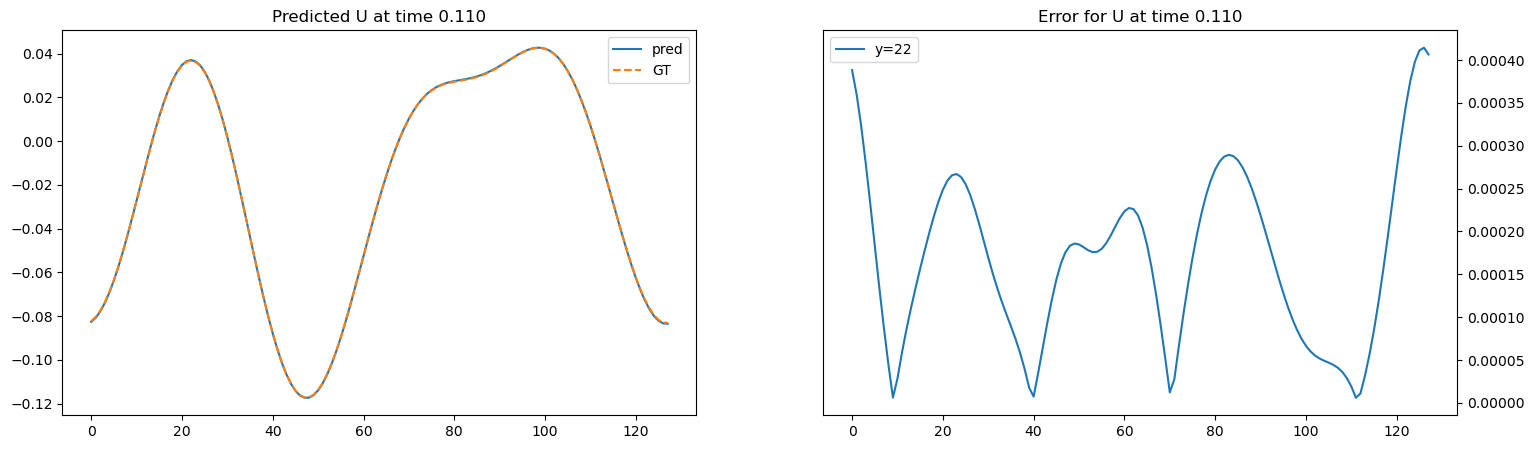

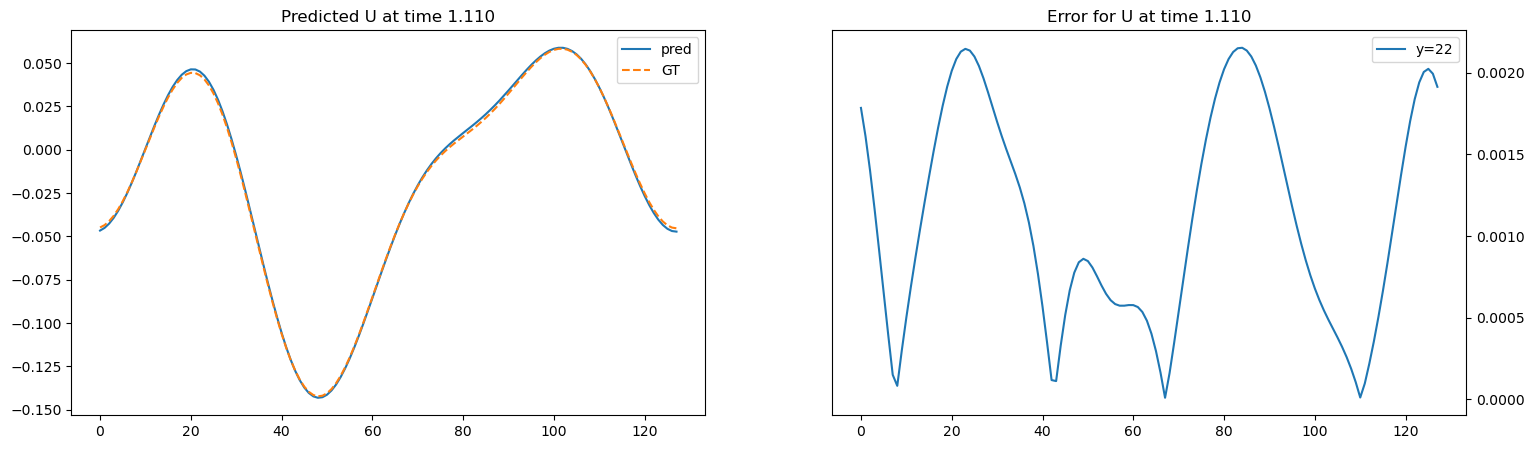

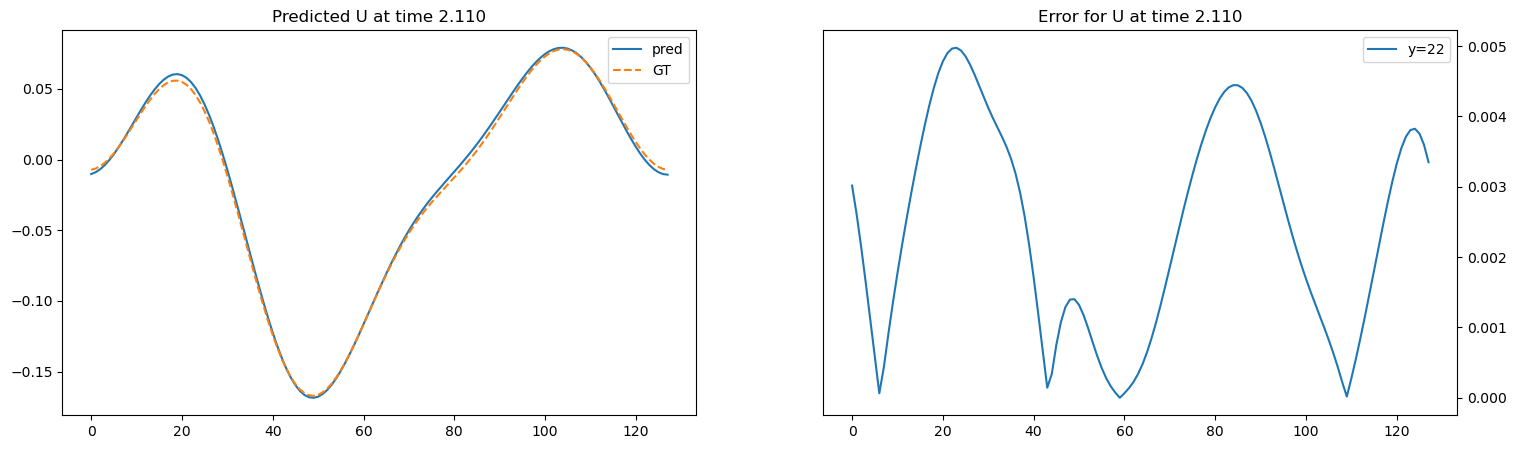

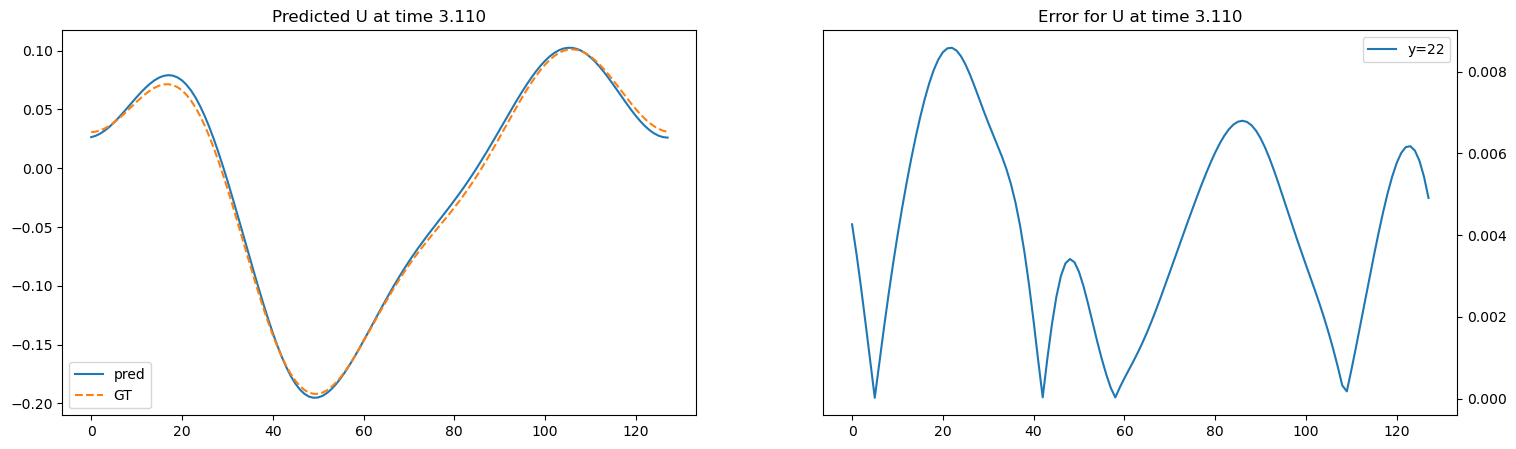

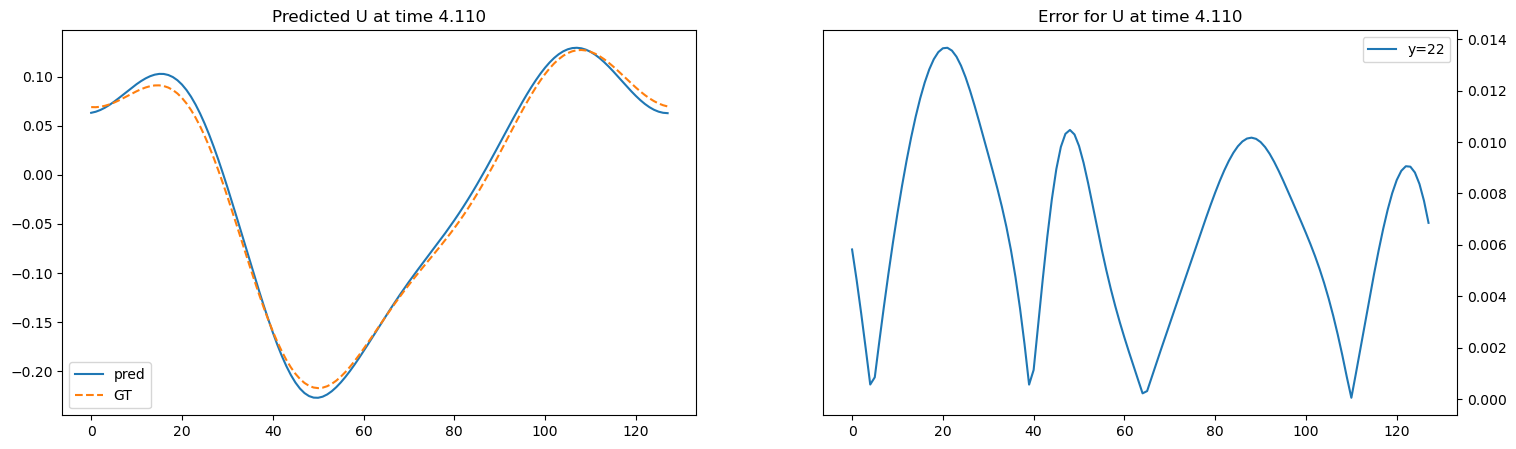

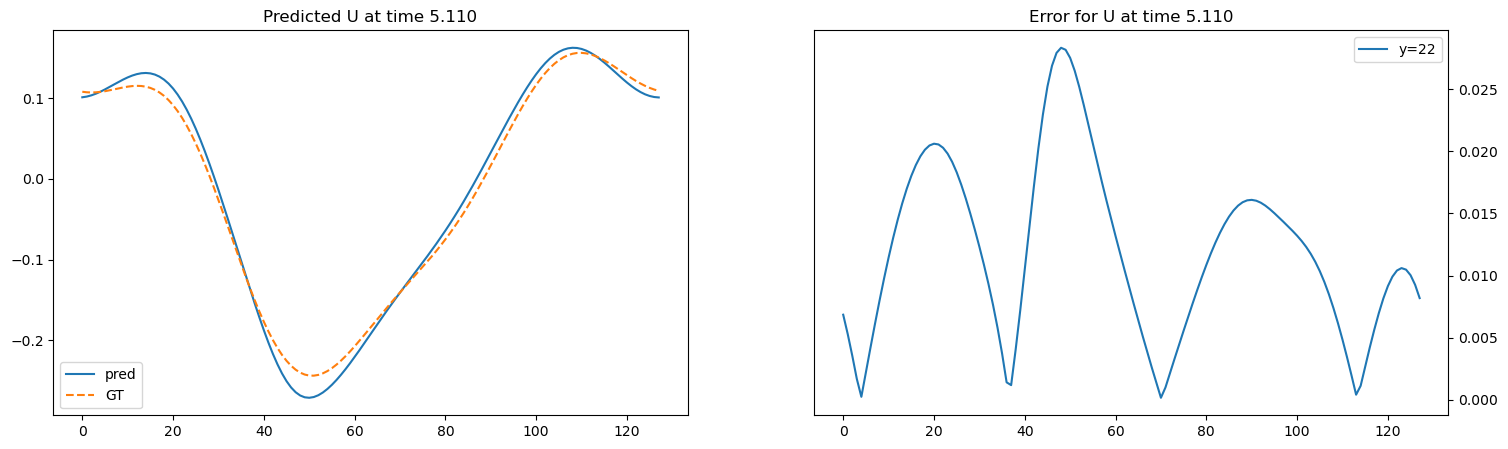

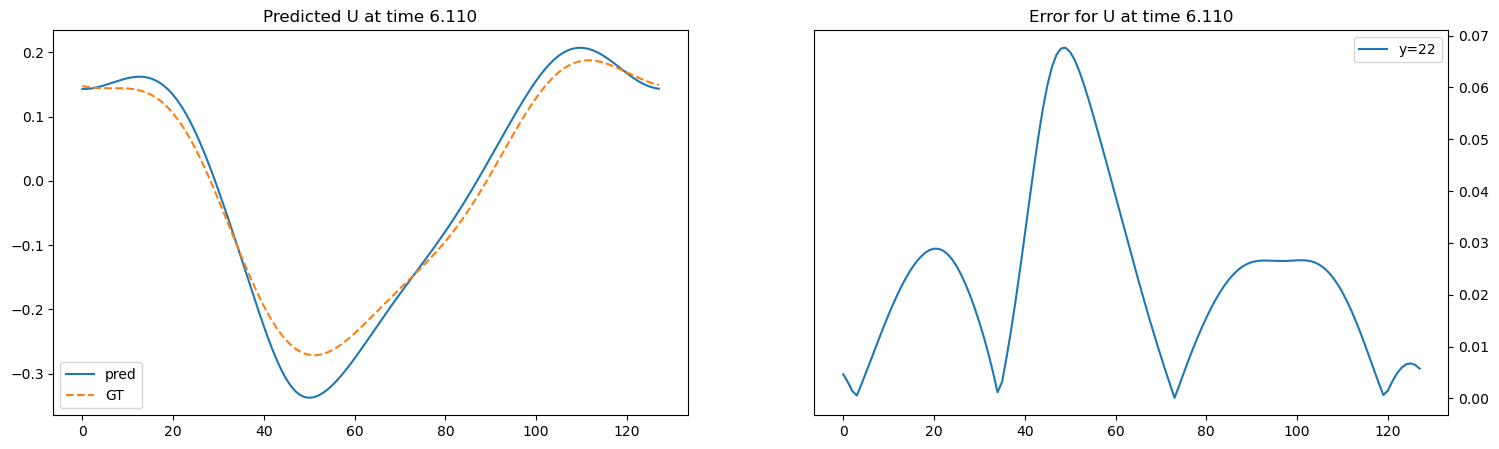

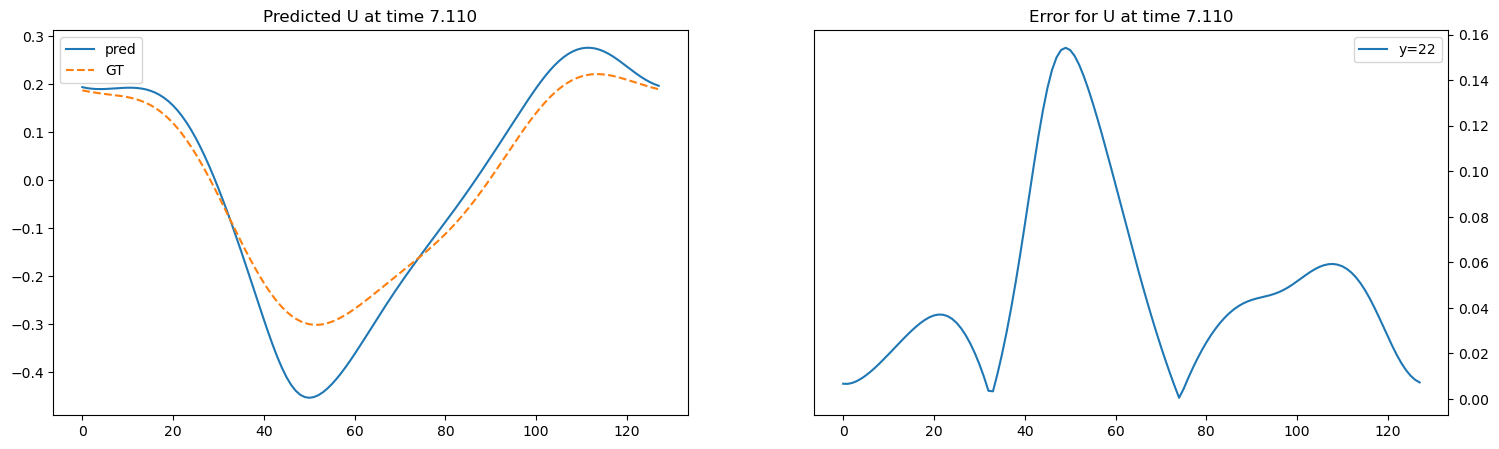

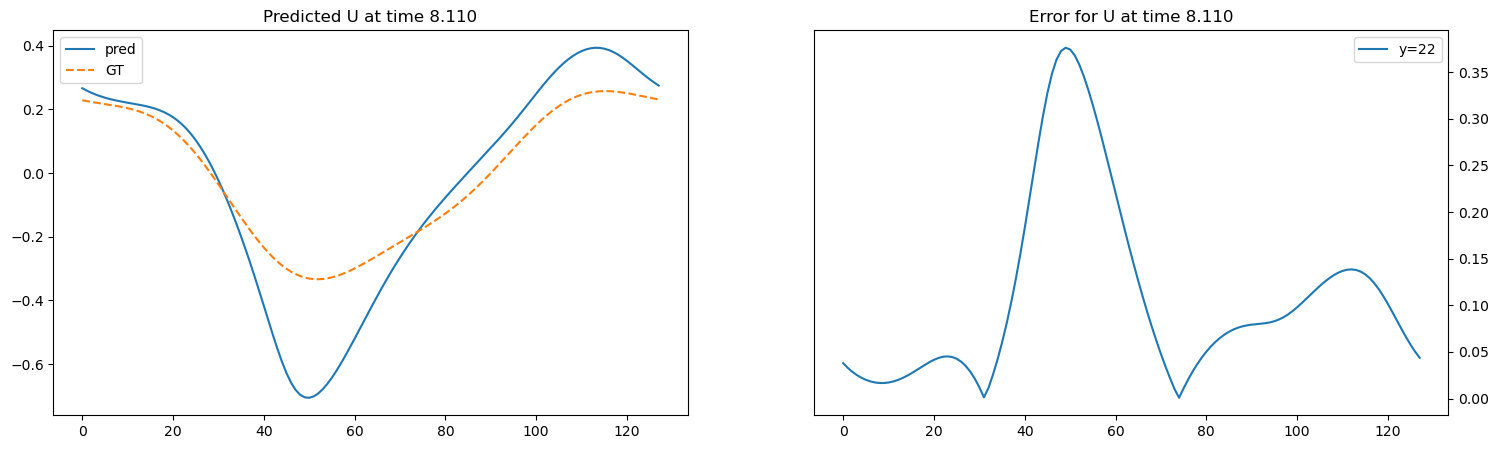

In [18]:
j= 22
for i in range(0, 900, 100):
    plt.figure(figsize=(18, 5))
    time_value = 0.01 * (11 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 2, 1)
   
    plt.plot(pred_u_c[i, :, j].detach().cpu().numpy(), label=f'pred')
    plt.plot(gt_u[i, :, j].detach().cpu().numpy(), '--', label=f'GT')
    plt.title(f"Predicted U at time {time_str}")
    plt.legend()
   # plt.colorbar()

    # Fourth plot: Error along center slice
    plt.subplot(1, 2, 2)
   
    plt.plot(np.abs(pred_u_c[i, :, j].detach().cpu().numpy() -gt_u[i, :, j].detach().cpu().numpy()), label=f'y={j}')
    plt.legend()
    plt.title(f"Error for U at time {time_str}")
    
    # Set y-ticks on the right
    plt.gca().yaxis.tick_right()
    #plt.savefig(f'./figures/fno/fno_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}_fixed_x_y={j}.png')
    plt.show()


In [19]:
# # Assume sample_u is your input tensor and model_u is your trained FNO model.
# # For this example, we assume sample_u has dimensions [time, spatial_dims...]
# # and that final_time represents a 1D spatial field. Adjust axes as needed for your data.

# pred_u_c = []           # List to store predictions at each time step
# fft_magnitudes = {}     # Dictionary to store FFT magnitudes for selected iterations

# # We'll monitor the FFT spectrum at these iteration numbers (you can adjust as needed)
# selected_iters = [100, 300, 600, 900]

# # Initialize the window with the first 100 time steps and add a batch dimension.
# window_u = sample_u[:100, :, :].unsqueeze(0)

# num_iterations = 900
# for i in trange(num_iterations):
#     outputs_u = model_u(window_u)
#     # Get the prediction at the final time step from the output sequence.
#     final_time = outputs_u.squeeze(0)[-1]
#     pred_u_c.append(final_time)
    
#     # At selected iterations, compute the FFT on the predicted field.
#     if (i + 1) in selected_iters:
#         # Compute the FFT along the spatial dimension.
#         # Here we assume final_time is a 2D field, where the FFT is taken over one spatial dimension.
#         # Adjust the dimension (dim=?) if your data is multi-dimensional.
#         fft_result = torch.fft.fft(final_time, dim=-1)
#         fft_mag = torch.abs(fft_result).detach().cpu().numpy()
#         fft_magnitudes[i + 1] = fft_mag

#     # Update the window: remove the oldest frame and add the new prediction.
#     window_u = torch.cat([window_u[:, 1:], final_time.unsqueeze(0).unsqueeze(0)], dim=1)

# # Plot the FFT magnitude spectrum for each selected iteration.
# for iter_num, mag in fft_magnitudes.items():
#     plt.figure()
#     plt.plot(mag)
#     plt.title(f'FFT Magnitude Spectrum at Iteration {iter_num}')
#     plt.xlabel('Frequency index')
#     plt.ylabel('Magnitude')
#     plt.show()


In [15]:
def compute_radial_energy_spectrum(matrix, num_bins=32):
    """
    Compute the radial energy spectrum for a 2D input matrix.

    Parameters:
    - matrix: 2D numpy array (spatial domain)
    - num_bins: Number of bins for the radial spectrum (each bin with a width of 1)

    Returns:
    - energy_bins: 1D array containing the total energy in each radial bin
    - bin_edges: Array of bin edges used in the histogram
    """
    # Compute the 2D FFT and shift zero frequency to the center
    F = np.fft.fft2(matrix)
    F_shifted = np.fft.fftshift(F)
    
    # Compute the energy (squared magnitude)
    energy = np.abs(F_shifted)**2

    # Get dimensions and compute distance (wave number) from the center
    nrows, ncols = matrix.shape
    center_row, center_col = nrows // 2, ncols // 2
    y, x = np.indices((nrows, ncols))
    r = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    
    # Define bins from 0 to num_bins (each bin width = 1)
    bin_edges = np.arange(0, num_bins + 1, 1)
    
    # Sum the energy in each radial bin
    energy_bins, _ = np.histogram(r, bins=bin_edges, weights=energy)
    
    return energy_bins, bin_edges

In [16]:
def compare_radial_spectra(pred_sequence, gt_sequence, num_bins=32):
    """
    Compute the radial energy spectra for both pred_sequence and gt_sequence.
    
    Parameters:
    - pred_sequence: numpy array of shape (T, dim, dim) for the predicted data
    - gt_sequence: numpy array of shape (T, dim, dim) for the ground truth data
    - num_bins: number of radial bins
    
    Returns:
    - pred_spectra: array of shape (T, num_bins) with radial energies for pred_sequence
    - gt_spectra: array of shape (T, num_bins) with radial energies for gt_sequence
    - bin_edges: the bin edges used in the computation
    """
    T = 900
    print(T)
    pred_spectra = []
    gt_spectra = []
    
    for t in range(T):
        pred_energy, bin_edges = compute_radial_energy_spectrum(pred_sequence[t], num_bins)
        gt_energy, _ = compute_radial_energy_spectrum(gt_sequence[t], num_bins)
        pred_spectra.append(pred_energy)
        gt_spectra.append(gt_energy)
    
    pred_spectra = np.array(pred_spectra)
    gt_spectra = np.array(gt_spectra)
    
    return pred_spectra, gt_spectra, bin_edges

In [21]:
def plot_average_spectra(pred_spectra, gt_spectra, bin_edges):
    """
    Plot the average radial energy spectrum for the predicted and ground truth sequences.
    
    Parameters:
    - pred_spectra: array of shape (T, num_bins)
    - gt_spectra: array of shape (T, num_bins)
    - bin_edges: bin edges array from the spectrum calculation
    """
    # Average spectra over time steps
    pred_avg = np.mean(pred_spectra, axis=0)
    gt_avg = np.mean(gt_spectra, axis=0)
    
    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    for i in range(0, len(pred_spectra), 100):
        plt.figure(figsize=(8, 5))
        #plt.axvline(x=7.5)
        plt.semilogy(bin_centers, pred_spectra[i], marker='o', label='Predicted')
        plt.semilogy(bin_centers, gt_spectra[i], marker='o', label='Ground Truth')
        plt.xlabel('Wave number')
        plt.ylabel('Energy')
        time_value = 0.1 * (11 + i)
        time_str = f"{time_value:.3f}" 
        plt.title(r'Radial Energy Spectrum time t = ' + time_str)
        plt.legend()
        plt.grid(True)
        #plt.savefig(f'./figures/fno/fno_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
        plt.show()
   
    plt.figure(figsize=(8, 5))
    
    plt.semilogy(bin_centers, pred_avg, marker='o', label='Predicted')
    plt.semilogy(bin_centers, gt_avg, marker='o', label='Ground Truth')
    plt.xlabel('Wave number')
    plt.ylabel('Energy')
    plt.title('Average Radial Energy Spectrum')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'./figures/fno/fno_avg_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
    plt.show()

900


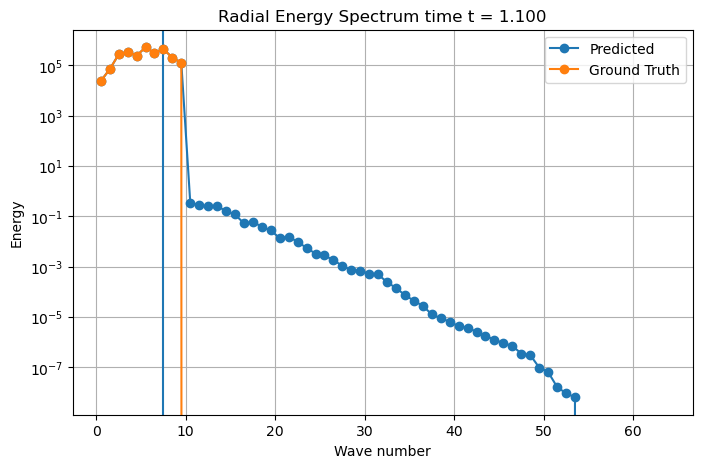

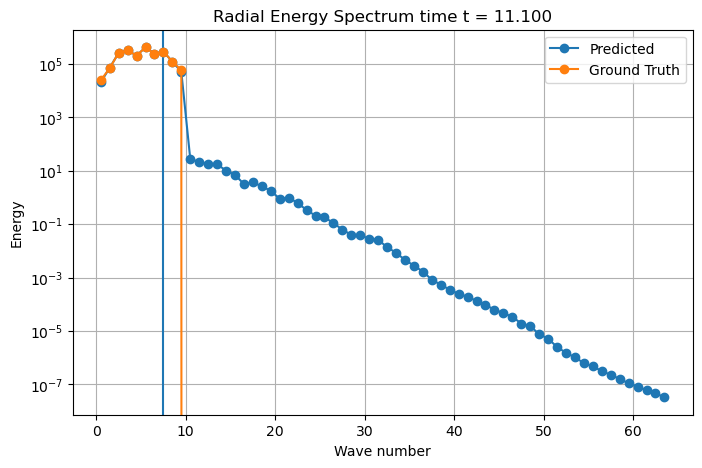

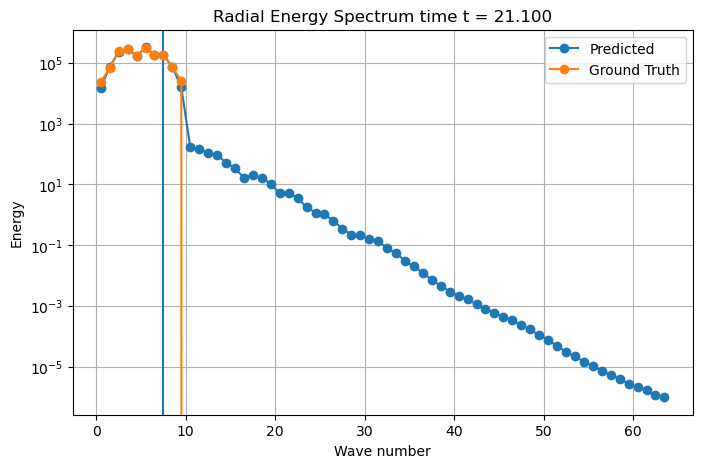

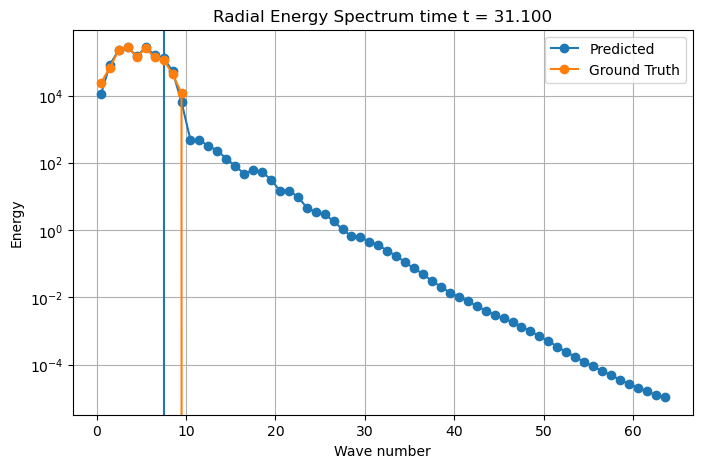

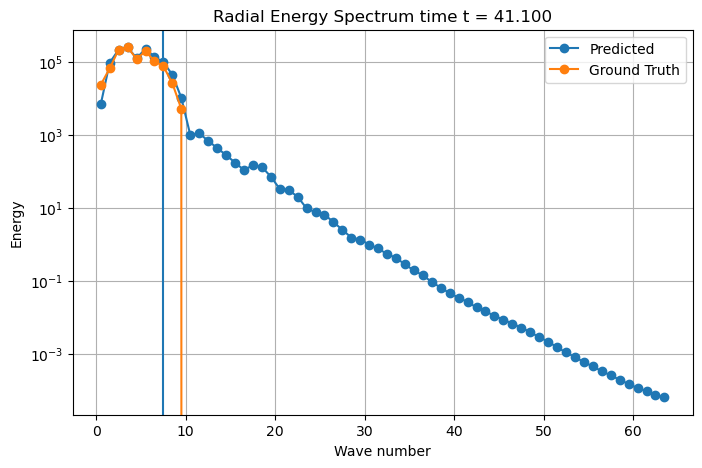

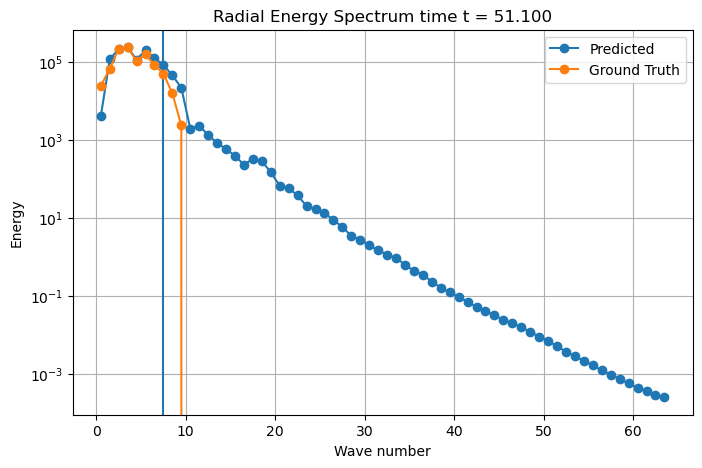

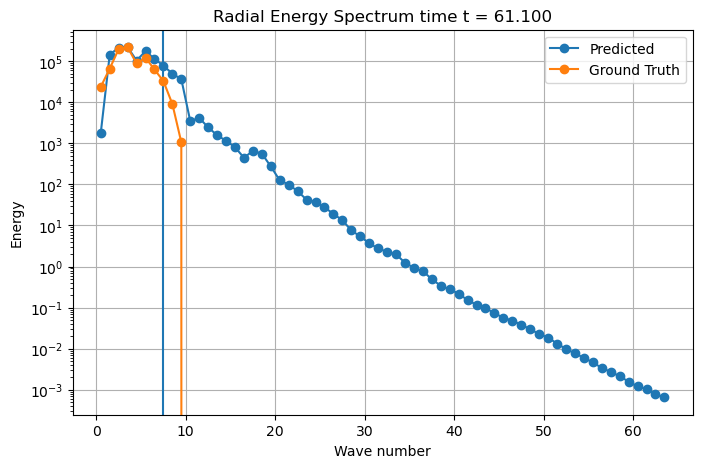

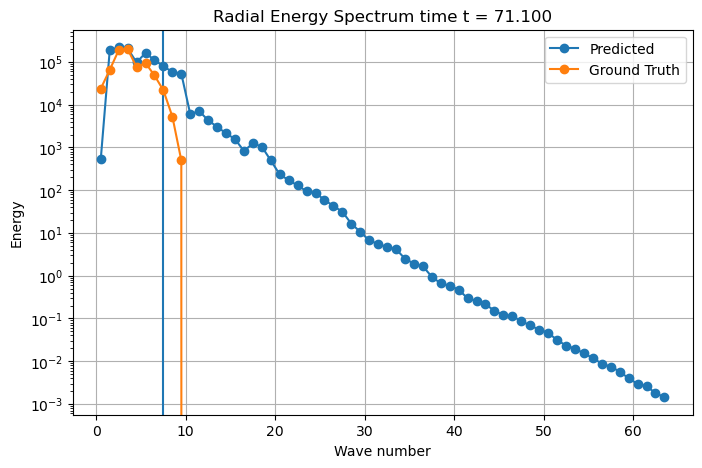

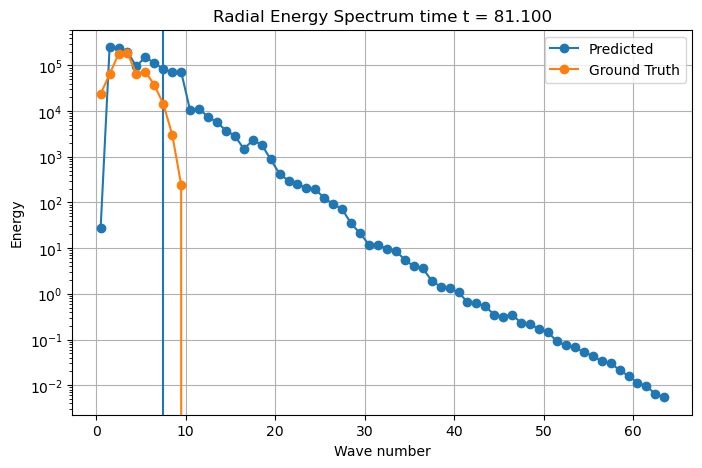

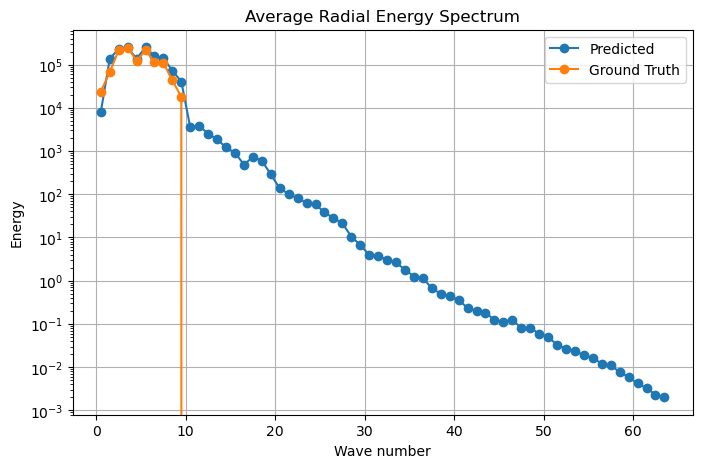

In [22]:
pred_spectra, gt_spectra, bin_edges = compare_radial_spectra(pred_u_c.cpu().detach().numpy(), gt_u.cpu(), num_bins=64)
plot_average_spectra(pred_spectra, gt_spectra, bin_edges)

In [24]:
# for i in range(pred_u_c.shape[0]):
#     plt.figure(figsize=(18, 5))
#     time_value = 0.1 * (11 + i)
#     time_str = f"{time_value:.3f}" 

#     # Left plot: Predicted U
#     plt.subplot(1, 3, 1)
#     plt.imshow(pred_u_c[i].detach().cpu().numpy(), cmap='hot')
#     plt.title(f"Predicted U at time {time_str}")
#     plt.colorbar()
#     plt.show()

In [20]:
total_params = sum(p.numel() for p in model_u.parameters())
print("Total parameters:", total_params)


Total parameters: 118158
